# Base Unsupervised Speech Emotion Recognition Model 
We will compare clustering alogrithm HDBSCAN and KMEANS 

we shall as look at popular library to extract paralinguitic features from speech. ( OPENSMILE and Librosa ) 

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
import opensmile


warnings.filterwarnings("ignore")

# Set the random seed for reproducibility
np.random.seed(42)

# Brief Overview of our pipeline 

- Load data -> Extract features and process it 
- Processed data -> standardise, reduce dimensions with UMAP
- Processed Processed Data -> Clustering 
- Clustered Results -> Evaluate data quality using metrics ( Silhouette score )

Silhouette score is a metric used to evaluate the quality of clusters in a clustering algorithm, ranging from -1 to 1, where higher values indicate better-defined clusters. Neagtive : data point might be assigned to the wrong cluster, as its closer to a different cluster than its own. 

Since we have Ground Truth Data, Maybe we can use ARI / NMI as a metric as well.  
ari : adjusted rand score 
nmi : normalized mutual info score 

## Loading and processing Audio Data 

In [2]:
# Define the directory where the RAVDESS audio files are stored.
audio_dir = "data/"

# Get a list of all audio file paths, ignoring 'archive' folder ( Archive folder holds the CREMA-D Dataset ) 
audio_files = []
for root, dirs, files in os.walk(audio_dir):
    # Skip the 'archive' folder
    if 'archive' in dirs:
        dirs.remove('archive')
    
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files.")

Found 1440 audio files.


## Feature Extraction Function 

In [3]:
def extract_features(file_path, n_mfcc=13):
    try:
        # Load audio file (mono, standardized sampling rate)
        y, sr = librosa.load(file_path, sr=16000)
        
        # Compute MFCCs and take statistics (mean and std for each coefficient)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        
        # Zero Crossing Rate as a simple prosodic feature
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # Combine features into one vector
        features = np.concatenate([mfccs_mean, mfccs_std, [zcr_mean, zcr_std]])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features for all audio files
features_list = []
file_names = []  # to keep track of file names

for file in audio_files:
    feat = extract_features(file)
    if feat is not None:
        features_list.append(feat)
        file_names.append(file)
        
features_array = np.array(features_list)
print("Extracted features shape:", features_array.shape)

Extracted features shape: (1440, 28)


## Standardize and Reduce Dimensionality 

Reduced features shape: (1440, 2)


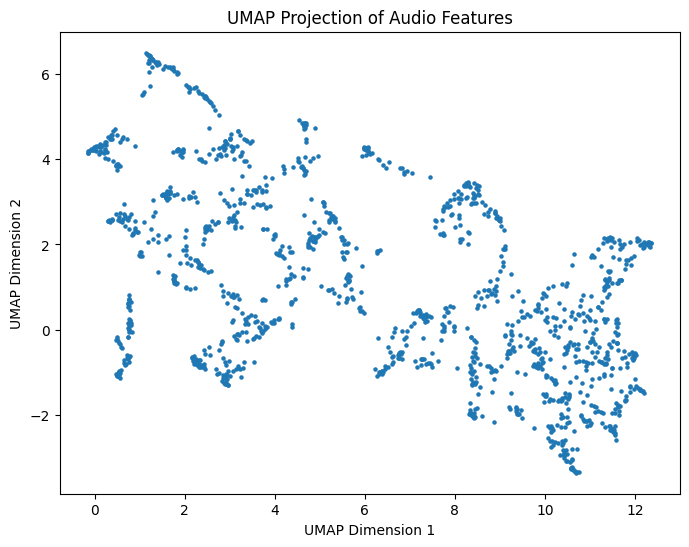

In [4]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)

print("Reduced features shape:", features_umap.shape)

# Plot UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Audio Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

## Clustering

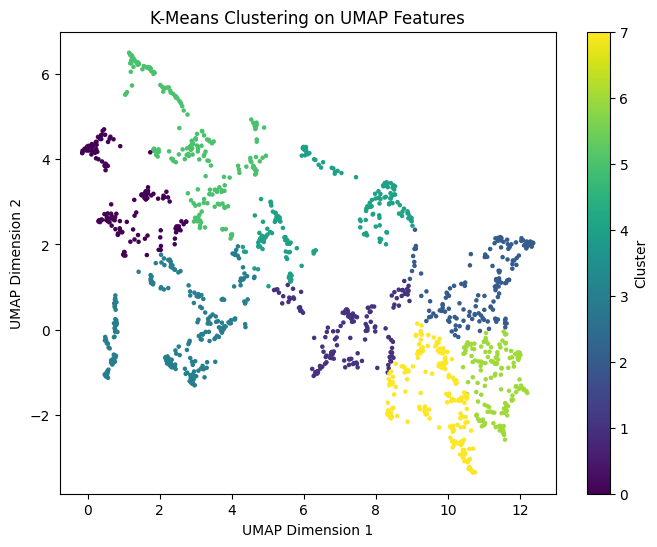

Silhouette Score (librosa + KMeans): 0.35778415
Davies-Bouldin Index (librosa + KMeans): 0.991313701138128
Calinski-Harabasz Index (librosa + KMeans): 1999.3617


In [5]:
# Set number of clusters (e.g., RAVDESS has 8 emotions, but unsupervised learning might reveal different structures)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features_umap)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=kmeans_labels, cmap="viridis", s=5)
plt.title("K-Means Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

librosa_kmeans_score = silhouette_score(features_umap, kmeans_labels)
librosa_kmeans_db = davies_bouldin_score(features_umap, kmeans_labels)
librosa_kmeans_ch = calinski_harabasz_score(features_umap, kmeans_labels)
print("Silhouette Score (librosa + KMeans):", librosa_kmeans_score)
print("Davies-Bouldin Index (librosa + KMeans):", librosa_kmeans_db)
print("Calinski-Harabasz Index (librosa + KMeans):", librosa_kmeans_ch)

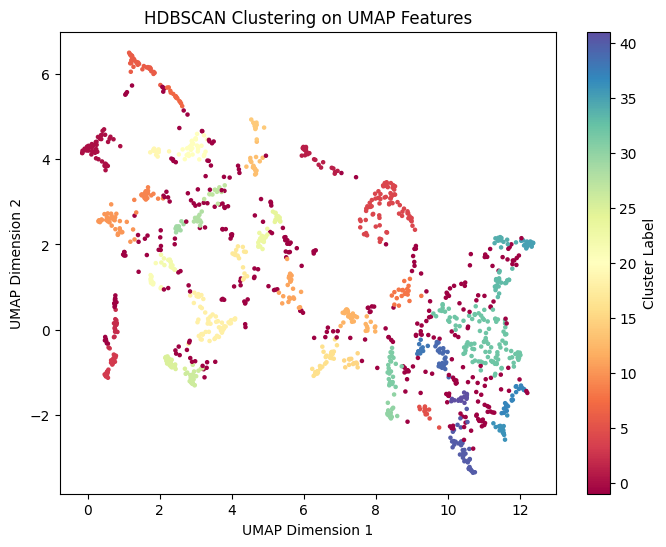

Silhouette Score (librosa + HDBSCAN): 0.61180663
Davies-Bouldin Index (librosa + HDBSCAN): 0.4142371257094394
Calinski-Harabasz Index (librosa + HDBSCAN): 3764.2312


In [6]:
# HDBSCAN clustering (automatically infers number of clusters and identifies noise)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = clusterer.fit_predict(features_umap)

# Visualize HDBSCAN clusters (note: label -1 indicates noise points)
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=hdbscan_labels, cmap="Spectral", s=5)
plt.title("HDBSCAN Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Silhouette score for HDBSCAN clustering (excluding noise points if present)
# Only consider points that are not labeled as noise (-1)
mask = hdbscan_labels != -1
if len(set(hdbscan_labels[mask])) > 1:
    librosa_hdbscan_score = silhouette_score(features_umap[mask], hdbscan_labels[mask])
    librosa_hdbscan_db = davies_bouldin_score(features_umap[mask], hdbscan_labels[mask])
    librosa_hdbscan_ch = calinski_harabasz_score(features_umap[mask], hdbscan_labels[mask])
    print("Silhouette Score (librosa + HDBSCAN):", librosa_hdbscan_score)
    print("Davies-Bouldin Index (librosa + HDBSCAN):", librosa_hdbscan_db)
    print("Calinski-Harabasz Index (librosa + HDBSCAN):", librosa_hdbscan_ch)

else:
    print("HDBSCAN clustering did not form distinct clusters or too many noise points.")

In [7]:
results = {
    "Method": ["librosa", "librosa"],
    "Clustering": ["KMeans", "HDBSCAN"],
    "Silhouette Score": [librosa_kmeans_score, librosa_hdbscan_score],
    "Davies-Bouldin Index": [librosa_kmeans_db, librosa_hdbscan_db],
    "Calinski-Harabasz Index": [librosa_kmeans_ch, librosa_hdbscan_ch],
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))

,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
1,librosa,HDBSCAN,0.611807,0.414237,3764.231201
0,librosa,KMeans,0.357784,0.991314,1999.361694


### Summary
K-Means Score (0.358):
This lower score indicates that the clusters are not very well separated and there may be considerable overlap, suggesting room for improvement with respect to either the chosen number of clusters, the feature set, or even trying a different clustering algorithm.

HDBSCAN Score (0.612):
A score of 0.612 is relatively good for clustering tasks. It indicates that, when considering only the points that HDBSCAN assigns to clusters (excluding noise), the clusters are more distinct and well-defined compared to the K-Means clustering. 

# OpenSmile vs Librosa 
- Extract feratures that have been optimized through extensive research in speech emotion recognition, including functional over low-level descriptors, this often leads to a richer description of paralinguistic properties compared to manually computed MFCCs or basic prosodic features with librosa.
- Feature set and level chosen : eGeMAPSv01a with Functionals
- Run the pipeline again and see the results 

In [8]:
# Initialize the OpenSMILE feature extractor with the eGeMAPS configuration
# Note: 'eGeMAPSv01a' is one of the available configurations.
smile = opensmile.Smile(
    feature_set='eGeMAPSv01a',   # Choose a feature set; other options include 'IS09_emotion', 'ComParE_2016', etc.
    feature_level='Functionals'  # Functionals summarise statistics (like mean, std, etc.) over the entire audio file
)

# Define the directory where the RAVDESS audio files are stored.
audio_dir = "data/"

# Get a list of all audio file paths, ignoring 'archive' folder ( Archive folder holds the CREMA-D Dataset ) 
audio_files = []
for root, dirs, files in os.walk(audio_dir):
    # Skip the 'archive' folder
    if 'archive' in dirs:
        dirs.remove('archive')
    
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files.")

# Function to extract features using OpenSMILE for a given audio file.
def extract_opensmile_features(file_path):
    try:
        # Process the file using OpenSMILE; this returns a pandas DataFrame
        features_df = smile.process_file(file_path)
        # Convert the DataFrame to a numpy array (we drop the 'name' column if present)
        features_array = features_df.values.squeeze()  # Ensure a 1D array per file
        return features_array
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features for all audio files using OpenSMILE
features_list = []
file_names = []  # to keep track of file names

for file in audio_files:
    feat = extract_opensmile_features(file)
    if feat is not None:
        features_list.append(feat)
        file_names.append(file)
        
# Convert feature list to a numpy array
features_array = np.array(features_list)
print("Extracted features shape using OpenSMILE:", features_array.shape)

Found 1440 audio files.
Extracted features shape using OpenSMILE: (1440, 88)


### Dimensionality Reduction and standardisation Step

Reduced features shape: (1440, 2)


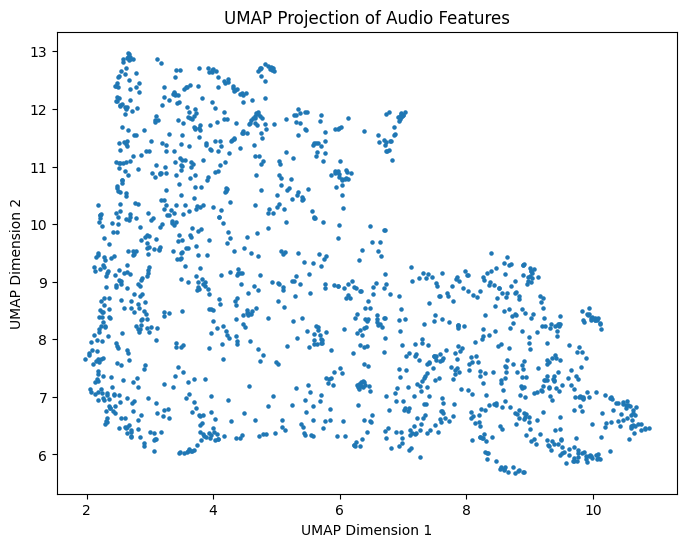

In [9]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)

print("Reduced features shape:", features_umap.shape)

# Plot UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Audio Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

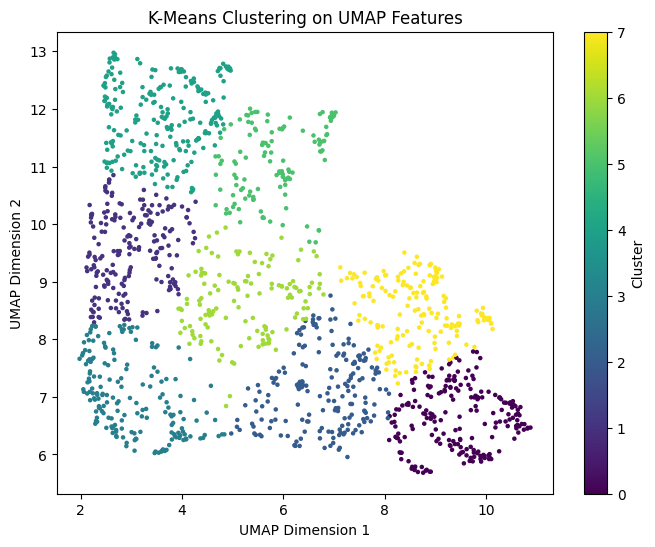

Silhouette Score (opensmile + KMeans): 0.4093683
Davies-Bouldin Index (opensmile + KMeans): 0.7835282871860731
alinski-Harabasz Index (opensmile + KMeans): 2160.9612


In [10]:
# Set number of clusters (e.g., RAVDESS has 8 emotions, but unsupervised learning might reveal different structures)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features_umap)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=kmeans_labels, cmap="viridis", s=5)
plt.title("K-Means Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

opensmile_kmeans_score = silhouette_score(features_umap, kmeans_labels)
opensmile_kmeans_db = davies_bouldin_score(features_umap, kmeans_labels)
opensmile_kmeans_ch = calinski_harabasz_score(features_umap, kmeans_labels)

print("Silhouette Score (opensmile + KMeans):", opensmile_kmeans_score)
print("Davies-Bouldin Index (opensmile + KMeans):", opensmile_kmeans_db)
print("alinski-Harabasz Index (opensmile + KMeans):", opensmile_kmeans_ch)

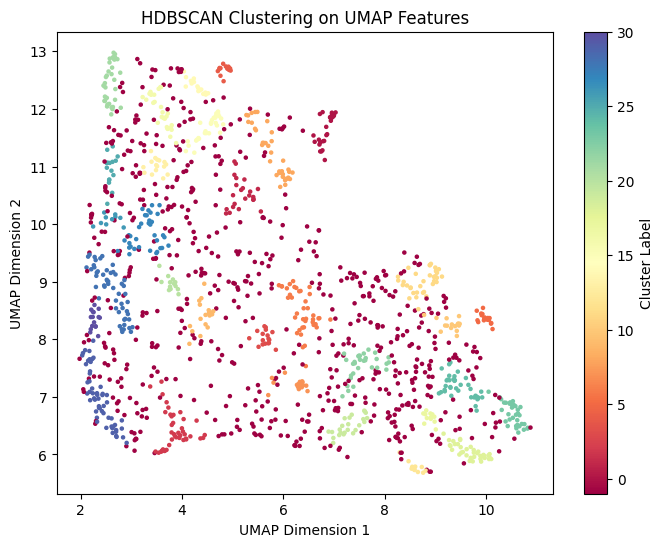

Silhouette Score opensmile (excluding noise): 0.5511576
Davies-Bouldin Index (opensmile + HDBSCAN): 0.5641106544311675
Calinski-Harabasz Index (opensmile + HDBSCAN): 2579.173


In [11]:
# HDBSCAN clustering (automatically infers number of clusters and identifies noise)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = clusterer.fit_predict(features_umap)

# Visualize HDBSCAN clusters (note: label -1 indicates noise points)
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=hdbscan_labels, cmap="Spectral", s=5)
plt.title("HDBSCAN Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Silhouette score for HDBSCAN clustering (excluding noise points if present)
# Only consider points that are not labeled as noise (-1)
mask = hdbscan_labels != -1
if len(set(hdbscan_labels[mask])) > 1:
    opensmile_hdbscan_score = silhouette_score(features_umap[mask], hdbscan_labels[mask])
    opensmile_hdbscan_db = davies_bouldin_score(features_umap[mask], hdbscan_labels[mask])
    opensmile_hdbscan_ch = calinski_harabasz_score(features_umap[mask], hdbscan_labels[mask])
    print("Silhouette Score opensmile (excluding noise):", opensmile_hdbscan_score)
    print("Davies-Bouldin Index (opensmile + HDBSCAN):", opensmile_hdbscan_db)
    print("Calinski-Harabasz Index (opensmile + HDBSCAN):", opensmile_hdbscan_ch)
else:
    print("HDBSCAN clustering did not form distinct clusters or too many noise points.")

In [12]:
# Comparison of all the Silohouette value and score 
results = {
    "Method": ["OpenSMILE", "OpenSMILE"],
    "Clustering": ["KMeans", "HDBSCAN"],
    "Silhouette Score": [opensmile_kmeans_score, opensmile_hdbscan_score],
    "Davies-Bouldin Index": [opensmile_kmeans_db, opensmile_hdbscan_db],
    "Calinski-Harabasz Index": [opensmile_kmeans_ch, opensmile_hdbscan_ch]
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))

,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
1,OpenSMILE,HDBSCAN,0.551158,0.564111,2579.173096
0,OpenSMILE,KMeans,0.409368,0.783528,2160.961182


# COMPARISON BETEWEEN OPENSMILE, LIBROSA, HDBSCAN AND KMEANS

In [13]:
# Table to show the different scores 

In [14]:
results = {
    "Method": ["librosa", "librosa", "OpenSMILE", "OpenSMILE"],
    "Clustering": ["KMeans", "HDBSCAN", "KMeans", "HDBSCAN"],
    "Silhouette Score": [librosa_kmeans_score, librosa_hdbscan_score, opensmile_kmeans_score, opensmile_hdbscan_score],
    "Davies-Bouldin Index": [librosa_kmeans_db, librosa_hdbscan_db, opensmile_kmeans_db, opensmile_hdbscan_db],
    "Calinski-Harabasz Index": [librosa_kmeans_ch, librosa_hdbscan_ch, opensmile_kmeans_ch, opensmile_hdbscan_ch]
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))


,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
1,librosa,HDBSCAN,0.611807,0.414237,3764.231201
3,OpenSMILE,HDBSCAN,0.551158,0.564111,2579.173096
2,OpenSMILE,KMeans,0.409368,0.783528,2160.961182
0,librosa,KMeans,0.357784,0.991314,1999.361694


From the result it would seem that Librosa Feature Extraction works the best with HDBSCAN clustering returning the highest Silhouette Score 

# Improvement Hyper-Parameter Tuning 
- Maybe can play with tuning UMAP parameters - like n_neighbors and min_dist  
- Improved K-Means Clustering and Parameter Tuning 
- Improved HSBSCAN - adjusting parameters such as min_cluster_size and min_samples. 

In [15]:
# Extract features for all audio files
features_list = []
file_names = []  # to keep track of file names

for file in audio_files:
    feat = extract_features(file)
    if feat is not None:
        features_list.append(feat)
        file_names.append(file)
        
features_array = np.array(features_list)
print("Extracted features shape:", features_array.shape) # Librosa features 

Extracted features shape: (1440, 28)


Reduced features shape: (1440, 2)


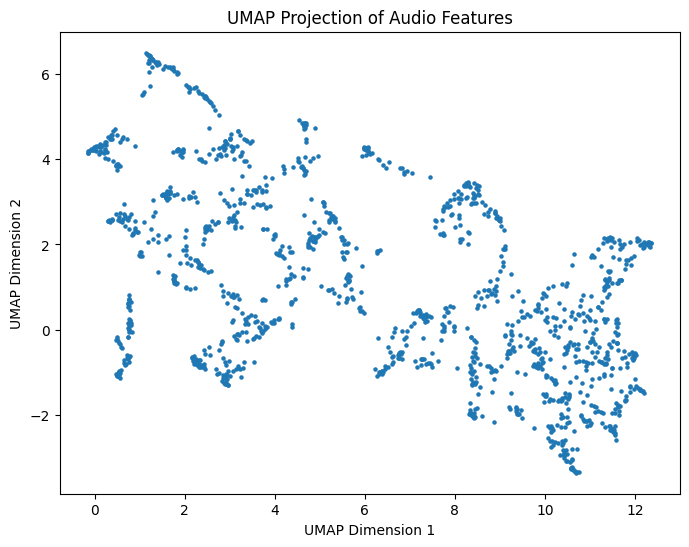

In [16]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)

print("Reduced features shape:", features_umap.shape)

# Plot UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Audio Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

min_cluster_size=5, min_samples=1, Silhouette Score=0.576
min_cluster_size=5, min_samples=3, Silhouette Score=0.595
min_cluster_size=5, min_samples=5, Silhouette Score=0.618
min_cluster_size=5, min_samples=10, Silhouette Score=0.609
min_cluster_size=5, min_samples=15, Silhouette Score=0.446
min_cluster_size=10, min_samples=1, Silhouette Score=0.570
min_cluster_size=10, min_samples=3, Silhouette Score=0.531
min_cluster_size=10, min_samples=5, Silhouette Score=0.587
min_cluster_size=10, min_samples=10, Silhouette Score=0.612
min_cluster_size=10, min_samples=15, Silhouette Score=0.446
min_cluster_size=15, min_samples=1, Silhouette Score=0.509
min_cluster_size=15, min_samples=3, Silhouette Score=0.510
min_cluster_size=15, min_samples=5, Silhouette Score=0.555
min_cluster_size=15, min_samples=10, Silhouette Score=0.584
min_cluster_size=15, min_samples=15, Silhouette Score=0.446
min_cluster_size=20, min_samples=1, Silhouette Score=0.506
min_cluster_size=20, min_samples=3, Silhouette Score=0.

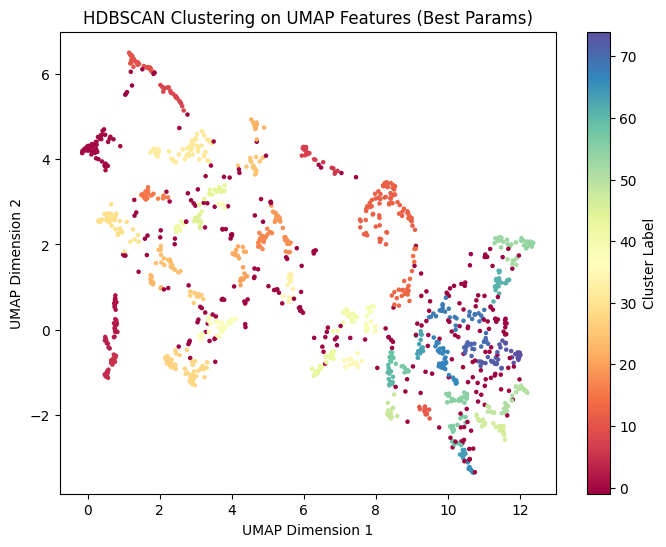

In [17]:
# Let's define a grid for HDBSCAN parameters
min_cluster_sizes = [5, 10, 15, 20, 25, 30]
min_samples_list = [1, 3, 5, 10, 15]

best_hdbscan_score = -1
best_params = {}
best_hdbscan_labels = None

for mcs in min_cluster_sizes:
    for ms in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        hdbscan_labels = clusterer.fit_predict(features_umap)
        # Exclude noise points (label=-1) for evaluation
        valid_idx = hdbscan_labels != -1
        if len(set(hdbscan_labels[valid_idx])) > 1:
            score = silhouette_score(features_umap[valid_idx], hdbscan_labels[valid_idx])
            print(f"min_cluster_size={mcs}, min_samples={ms}, Silhouette Score={score:.3f}")
            if score > best_hdbscan_score:
                best_hdbscan_score = score
                best_params = {'min_cluster_size': mcs, 'min_samples': ms}
                best_hdbscan_labels = hdbscan_labels
        else:
            print(f"min_cluster_size={mcs}, min_samples={ms}: Not enough clusters.")

print("\nBest HDBSCAN parameters:", best_params, "with silhouette score:", best_hdbscan_score)

# Visualize best HDBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=best_hdbscan_labels, cmap="Spectral", s=5)
plt.title("HDBSCAN Clustering on UMAP Features (Best Params)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

In [18]:
# Get all labels assigned by HDBSCAN
labels = best_hdbscan_labels

# Count clusters (excluding label -1 which is noise)
unique_clusters = np.unique(labels[labels != -1])
num_clusters = len(unique_clusters)

# Also count how many noise points
num_noise_points = np.sum(labels == -1)
noise_ratio = num_noise_points / len(labels)

print(f"Number of clusters (excluding noise): {num_clusters}")
print(f"Number of noise points: {num_noise_points}")
print(f"Noise ratio: {noise_ratio:.2%}")

Number of clusters (excluding noise): 75
Number of noise points: 269
Noise ratio: 18.68%


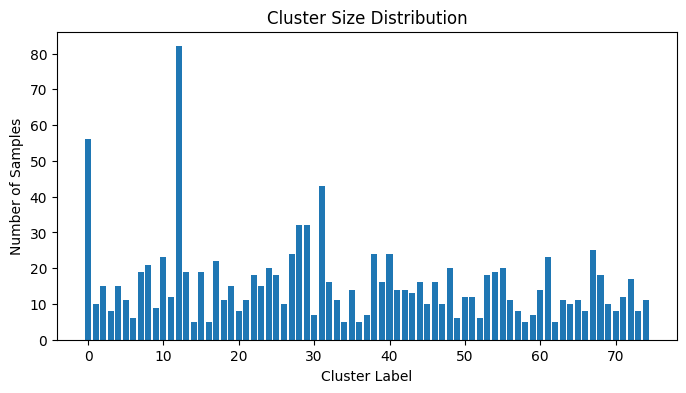

In [19]:
# Cluster size distribution (excluding noise)
labels_wo_noise = labels[labels != -1]
plt.figure(figsize=(8, 4))
plt.hist(labels_wo_noise, bins=np.arange(labels_wo_noise.min(), labels_wo_noise.max()+2)-0.5, rwidth=0.8)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.show()

It would seem that the parameters used is already the best parameters that we have so far. 
We shall carry out the next portion with HDBScan and Librosa Settings. 
75 Clusters were found, this is more than the the 8 in the data set, however since it is unsupervised dataset. 
We might be able to find clusters that are not labelled together for example instead of just Sad it might be a Depressed Cluster. Different severity of emotions could be found.

# Combined Data Set with the CREMA-D
Let us re-run the entire pipeline with the combined dataset

In [46]:
# Define the directory where the RAVDESS audio files are stored.
# Adjust this path to the location of your dataset.
audio_dir = "data/"

# Get a list of all audio file paths
audio_files = []
for root, dirs, files in os.walk(audio_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files.")

Found 8882 audio files.


### Let us do the comparison with the new dataset 

Extracted features shape: (8882, 28)
Reduced features shape: (8882, 2)


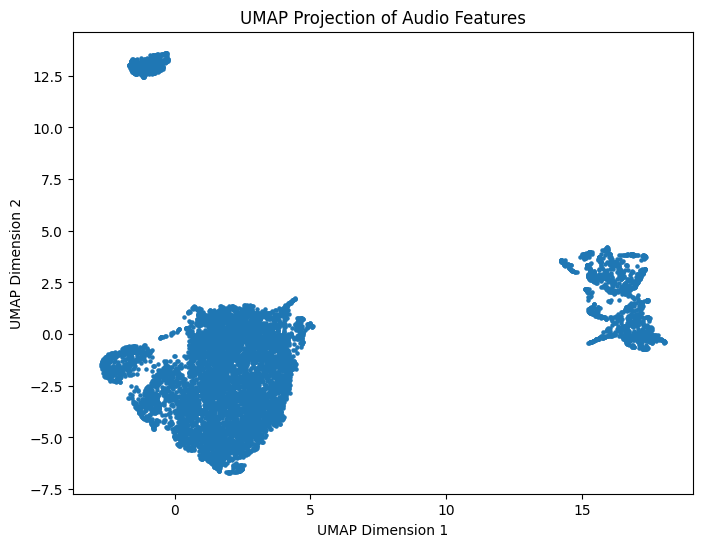

In [47]:
# Feature Extraction For Librosa 

# Extract features for all audio files
features_list = []
file_names = []  # to keep track of file names

for file in audio_files:
    feat = extract_features(file)
    if feat is not None:
        features_list.append(feat)
        file_names.append(file)
        
features_array = np.array(features_list)
print("Extracted features shape:", features_array.shape)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)

print("Reduced features shape:", features_umap.shape)

# Plot UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Audio Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

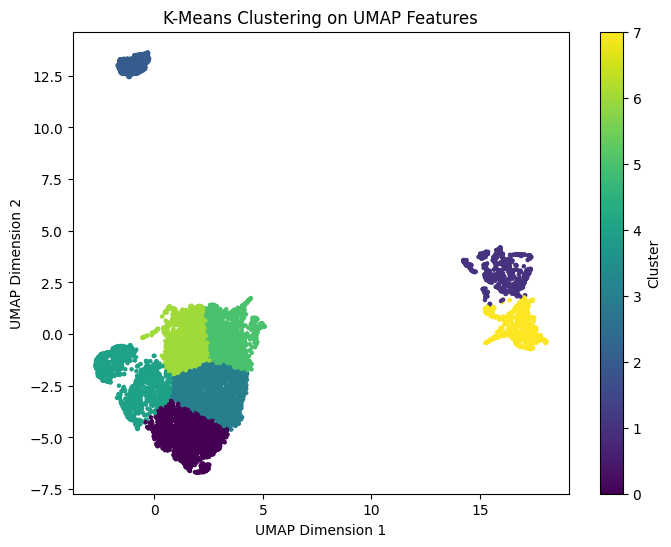

Silhouette Score (librosa + KMeans): 0.43033543
Davies-Bouldin Index (librosa + KMeans): 0.7440214983721019
Calinski-Harabasz Index (librosa + KMeans): 47408.18


In [48]:
# Set number of clusters (e.g., RAVDESS has 8 emotions, but unsupervised learning might reveal different structures)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features_umap)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=kmeans_labels, cmap="viridis", s=5)
plt.title("K-Means Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

librosa_kmeans_score = silhouette_score(features_umap, kmeans_labels)
librosa_kmeans_db = davies_bouldin_score(features_umap, kmeans_labels)
librosa_kmeans_ch = calinski_harabasz_score(features_umap, kmeans_labels)
print("Silhouette Score (librosa + KMeans):", librosa_kmeans_score)
print("Davies-Bouldin Index (librosa + KMeans):", librosa_kmeans_db)
print("Calinski-Harabasz Index (librosa + KMeans):", librosa_kmeans_ch)

### HDBSCAN

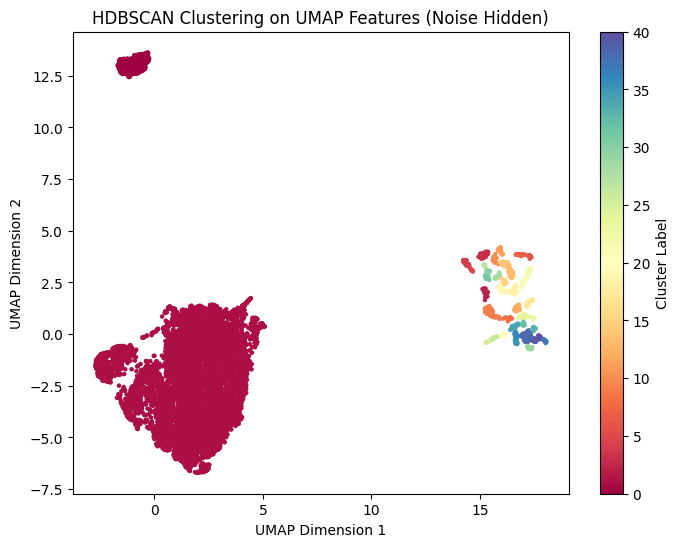

Silhouette Score (librosa + HDBSCAN): 0.7549656
Davies-Bouldin Index (librosa + HDBSCAN): 0.3908083813851507
Calinski-Harabasz Index (librosa + HDBSCAN): 1368.0422


In [51]:
# HDBSCAN clustering (automatically infers number of clusters and identifies noise)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = clusterer.fit_predict(features_umap)

# Filter out noise
mask = hdbscan_labels != -1
umap_clustered = features_umap[mask]
labels_clustered = hdbscan_labels[mask]

# Plot only clustered points (no noise)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_clustered[:, 0], umap_clustered[:, 1],
    c=labels_clustered, cmap="Spectral", s=5
)
plt.title("HDBSCAN Clustering on UMAP Features (Noise Hidden)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


# Silhouette score for HDBSCAN clustering (excluding noise points if present)
# Only consider points that are not labeled as noise (-1)
mask = hdbscan_labels != -1
if len(set(hdbscan_labels[mask])) > 1:
    librosa_hdbscan_score = silhouette_score(features_umap[mask], hdbscan_labels[mask])
    librosa_hdbscan_db = davies_bouldin_score(features_umap[mask], hdbscan_labels[mask])
    librosa_hdbscan_ch = calinski_harabasz_score(features_umap[mask], hdbscan_labels[mask])
    print("Silhouette Score (librosa + HDBSCAN):", librosa_hdbscan_score)
    print("Davies-Bouldin Index (librosa + HDBSCAN):", librosa_hdbscan_db)
    print("Calinski-Harabasz Index (librosa + HDBSCAN):", librosa_hdbscan_ch)

else:
    print("HDBSCAN clustering did not form distinct clusters or too many noise points.")

In [50]:
results = {
    "Method": ["librosa", "librosa"],
    "Clustering": ["KMeans", "HDBSCAN"],
    "Silhouette Score": [librosa_kmeans_score, librosa_hdbscan_score],
    "Davies-Bouldin Index": [librosa_kmeans_db, librosa_hdbscan_db],
    "Calinski-Harabasz Index": [librosa_kmeans_ch, librosa_hdbscan_ch],
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))

,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
1,librosa,HDBSCAN,0.754966,0.390808,1368.042236
0,librosa,KMeans,0.430335,0.744021,47408.179688


## OpenSmile next 

In [29]:
# Extract features for all audio files using OpenSMILE
features_list = []
file_names = []  # to keep track of file names

for file in audio_files:
    feat = extract_opensmile_features(file)
    if feat is not None:
        features_list.append(feat)
        file_names.append(file)
        
# Convert feature list to a numpy array
features_array = np.array(features_list)
print("Extracted features shape using OpenSMILE:", features_array.shape)

Extracted features shape using OpenSMILE: (8882, 88)


Reduced features shape: (8882, 2)


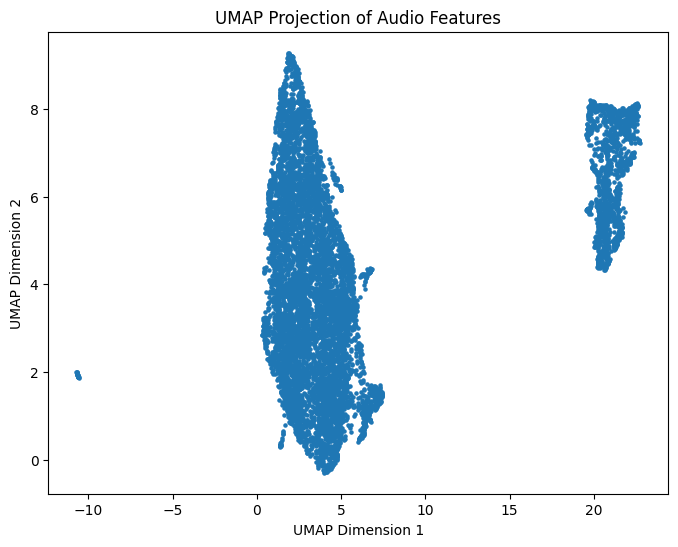

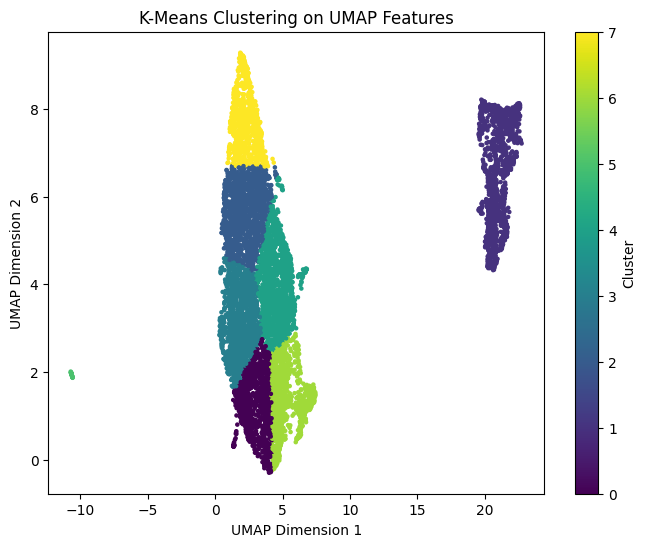

Silhouette Score (opensmile + KMeans): 0.4480889
Davies-Bouldin Index (opensmile + KMeans): 0.6807895024155116
alinski-Harabasz Index (opensmile + KMeans): 50399.48


In [30]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)

print("Reduced features shape:", features_umap.shape)

# Plot UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Audio Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

# Set number of clusters (e.g., RAVDESS has 8 emotions, but unsupervised learning might reveal different structures)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features_umap)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=kmeans_labels, cmap="viridis", s=5)
plt.title("K-Means Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

opensmile_kmeans_score = silhouette_score(features_umap, kmeans_labels)
opensmile_kmeans_db = davies_bouldin_score(features_umap, kmeans_labels)
opensmile_kmeans_ch = calinski_harabasz_score(features_umap, kmeans_labels)

print("Silhouette Score (opensmile + KMeans):", opensmile_kmeans_score)
print("Davies-Bouldin Index (opensmile + KMeans):", opensmile_kmeans_db)
print("alinski-Harabasz Index (opensmile + KMeans):", opensmile_kmeans_ch)

### HDBSCAN

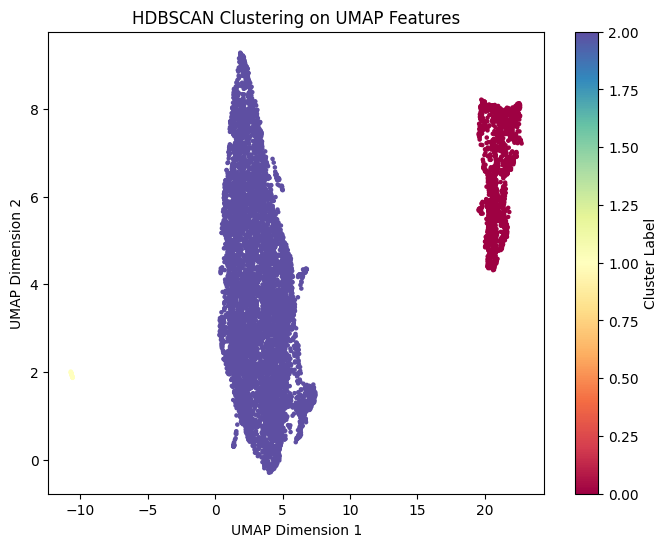

Silhouette Score opensmile (excluding noise): 0.782711
Davies-Bouldin Index (opensmile + HDBSCAN): 0.19927981763984826
Calinski-Harabasz Index (opensmile + HDBSCAN): 31367.02


In [31]:
# HDBSCAN clustering (automatically infers number of clusters and identifies noise)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = clusterer.fit_predict(features_umap)

# Visualize HDBSCAN clusters (note: label -1 indicates noise points)
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=hdbscan_labels, cmap="Spectral", s=5)
plt.title("HDBSCAN Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Silhouette score for HDBSCAN clustering (excluding noise points if present)
# Only consider points that are not labeled as noise (-1)
mask = hdbscan_labels != -1
if len(set(hdbscan_labels[mask])) > 1:
    opensmile_hdbscan_score = silhouette_score(features_umap[mask], hdbscan_labels[mask])
    opensmile_hdbscan_db = davies_bouldin_score(features_umap[mask], hdbscan_labels[mask])
    opensmile_hdbscan_ch = calinski_harabasz_score(features_umap[mask], hdbscan_labels[mask])
    print("Silhouette Score opensmile (excluding noise):", opensmile_hdbscan_score)
    print("Davies-Bouldin Index (opensmile + HDBSCAN):", opensmile_hdbscan_db)
    print("Calinski-Harabasz Index (opensmile + HDBSCAN):", opensmile_hdbscan_ch)
else:
    print("HDBSCAN clustering did not form distinct clusters or too many noise points.")

In [32]:
# Comparison of all the Silohouette value and score 
results = {
    "Method": ["OpenSMILE", "OpenSMILE"],
    "Clustering": ["KMeans", "HDBSCAN"],
    "Silhouette Score": [opensmile_kmeans_score, opensmile_hdbscan_score],
    "Davies-Bouldin Index": [opensmile_kmeans_db, opensmile_hdbscan_db],
    "Calinski-Harabasz Index": [opensmile_kmeans_ch, opensmile_hdbscan_ch]
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))

,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
1,OpenSMILE,HDBSCAN,0.782711,0.19928,31367.019531
0,OpenSMILE,KMeans,0.448089,0.68079,50399.480469


In [33]:
results = {
    "Method": ["librosa", "librosa", "OpenSMILE", "OpenSMILE"],
    "Clustering": ["KMeans", "HDBSCAN", "KMeans", "HDBSCAN"],
    "Silhouette Score": [librosa_kmeans_score, librosa_hdbscan_score, opensmile_kmeans_score, opensmile_hdbscan_score],
    "Davies-Bouldin Index": [librosa_kmeans_db, librosa_hdbscan_db, opensmile_kmeans_db, opensmile_hdbscan_db],
    "Calinski-Harabasz Index": [librosa_kmeans_ch, librosa_hdbscan_ch, opensmile_kmeans_ch, opensmile_hdbscan_ch]
}
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="Silhouette Score", ascending=False))


,Method,Clustering,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
3,OpenSMILE,HDBSCAN,0.782711,0.199280,31367.019531
1,librosa,HDBSCAN,0.754966,0.390808,1368.042236
2,OpenSMILE,KMeans,0.448089,0.680790,50399.480469
0,librosa,KMeans,0.430335,0.744021,47408.179688


In [40]:
import pandas as pd
from tabulate import tabulate

# RAVDESS dataset
ravdess_data = [
    [1, "librosa", "HDBSCAN", 0.611807, 0.414237, 3764.231201],
    [3, "OpenSMILE", "HDBSCAN", 0.551158, 0.564111, 2579.173096],
    [2, "OpenSMILE", "KMeans", 0.409368, 0.783528, 2160.961182],
    [0, "librosa", "KMeans", 0.357784, 0.991314, 1999.361694],
]

# RAVDESS + CREMA-D dataset
combined_data = [
    [3, "OpenSMILE", "HDBSCAN", 0.782711, 0.199280, 31367.019531],
    [1, "librosa", "HDBSCAN", 0.754966, 0.390808, 1368.042236],
    [2, "OpenSMILE", "KMeans", 0.448089, 0.680790, 50399.480469],
    [0, "librosa", "KMeans", 0.430335, 0.744021, 47408.179688],
]

columns = ["Method", "Feature Set", "Clustering", "Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"]

# Create and round DataFrames
df_ravdess = pd.DataFrame(ravdess_data, columns=columns).sort_values("Method").round(3)
df_combined = pd.DataFrame(combined_data, columns=columns).sort_values("Method").round(3)

# Display tables
print("RAVDESS Dataset:\n")
print(tabulate(df_ravdess, headers='keys', tablefmt='grid', showindex=False))

print("\nRAVDESS + CREMA-D Dataset:\n")
print(tabulate(df_combined, headers='keys', tablefmt='grid', showindex=False))

RAVDESS Dataset:

+----------+---------------+--------------+--------------------+------------------------+---------------------------+
|   Method | Feature Set   | Clustering   |   Silhouette Score |   Davies-Bouldin Index |   Calinski-Harabasz Index |
+==========+===============+==============+====================+========================+===========================+
|        0 | librosa       | KMeans       |              0.358 |                  0.991 |                   1999.36 |
+----------+---------------+--------------+--------------------+------------------------+---------------------------+
|        1 | librosa       | HDBSCAN      |              0.612 |                  0.414 |                   3764.23 |
+----------+---------------+--------------+--------------------+------------------------+---------------------------+
|        2 | OpenSMILE     | KMeans       |              0.409 |                  0.784 |                   2160.96 |
+----------+---------------+----------

Some insights we can pull from the statistics 

RAVDESS 
- Best Perfroming Librosa HDBSCAN ( 0.612 Silhoutte Score and lowest DBI and Highest CHI ) however the clustering in the diagram shows a lot of noise. 

RAVDEES + CREMA-D 
- OPENSMILE + HDBSCAN ( 0.783 Silhoutte Score and Lowest DBI )  Clustering did not make sense as there was only one cluster and noise.  
- LIBROSA + HSBSCAN ( 0.7755 Silhoutte Score and High CHI ), Good amount of clusters however large amount of noise points.
- KMeans + OpenSmile ( 0.448 Silhoutte Score and 0.681 Davies-Boulidin Index and 5000 Calinski Harabasz Index ). Good Clustering.
- KMeans + Librosa ( 0.43 Shihhoutte Score and 0.744 Davies-Boulding Index and 47408 Calinski Harabaz Index ). Good Clustering as well. 

# Final Conclusions and decisions
- We shall make our judgement purely on the RAVDESS + CEREMA-D Dataset, Since the RAVDESS Dataset lacks lexcial content for the second part of this study.
- Perfromance of HDBSCAN might be questionable 
- The OpenSmile Library seems to be Outperforming the Librosa ini all three of our metrics for KMeans.